In [1]:
from data.mnist import MNIST, MNIST_NORMALIZATION
from data.emnist import EMNIST
from model.cnn import simple_cnn
from torchvision import datasets,transforms
import torch
import numpy as np
from maha import maha_distance

from sklearn.metrics import precision_recall_curve,roc_auc_score
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,even=True,transform=tf)
test_data = MNIST('./dataset/',download=True,even=True,transform=tf,train=False)
near_ood = MNIST('./dataset/',download=True,even=False,transform=tf,train=False)
far_ood = EMNIST('./dataset/',split='letters',download= True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size = 128,shuffle=True)
near_ood_loader = torch.utils.data.DataLoader(near_ood,batch_size = 128,shuffle=True)
far_ood_loader = torch.utils.data.DataLoader(far_ood,batch_size = 128,shuffle=True)

In [3]:
model = simple_cnn(y_dim=5).to('cuda')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)
maha = maha_distance(5)

In [4]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward>)


In [5]:
ftrain = []
with torch.no_grad():
    for image,label in train_loader:
        feature = model.net(image.to('cuda'))
        ftrain += feature.cpu().numpy().tolist()
maha.model_feature(ftrain)

(128, 128)


In [8]:
maha.type = 'MD'
ftest= []
with torch.no_grad():
    for image,label in test_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
test_score = maha.score(ftest)
print(test_score.shape)
print(np.mean(test_score))

ftest= []
with torch.no_grad():
    for image,label in near_ood_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
near_ood_score = maha.score(ftest)
print(np.mean(near_ood_score))

ftest= []
with torch.no_grad():
    for e, (image,label) in enumerate(far_ood_loader):
        if e >50:
            break
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
far_ood_score = maha.score(ftest)
print(np.mean(far_ood_score))

# T = 5000
# far_ood_score = np.exp(far_ood_score/T)
# near_ood_score = np.exp(near_ood_score/T)
# test_score = np.exp(test_score/T)

MD
(4926,)
266.7825677671115
MD
512.5967997628813
MD
439.02974675128615


0.8473354003460918
0.7912170279449579
0.6140106811348899


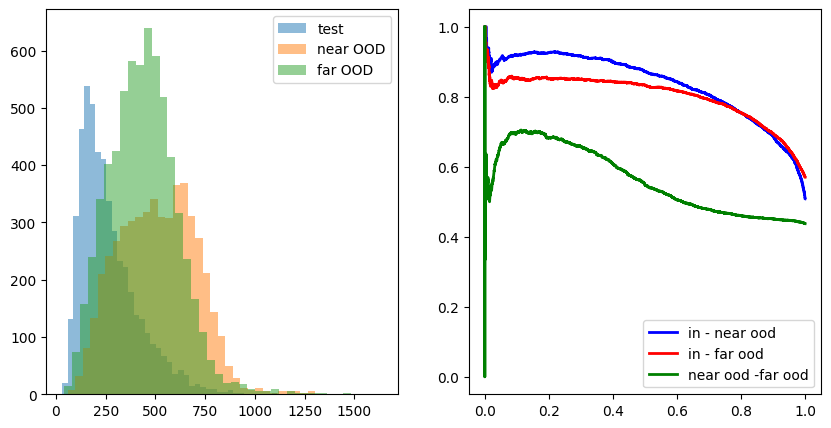

In [9]:
data_near = np.concatenate((test_score,near_ood_score))
t1 = np.zeros_like(test_score)
t2 = np.ones_like(near_ood_score)
data_label_n = np.concatenate((t1,t2))
plt.figure(figsize=(10,5))
plt.title("{}".format(maha.type))
plt.subplot(1,2,1)
ncounts, nbins = np.histogram(near_ood_score,bins=40)
tcounts, tbins = np.histogram(test_score,bins=40)
fcounts, fbins = np.histogram(far_ood_score,bins=40)

plt.hist(tbins[:-1], tbins, weights=tcounts, alpha=0.5,label = 'test')
plt.hist(nbins[:-1], nbins, weights=ncounts, alpha=0.5, label = 'near OOD')
plt.hist(fbins[:-1], fbins, weights=fcounts, alpha=0.5 , label= 'far OOD')
plt.legend()


plt.subplot(1,2,2)
precision, recall, _   = precision_recall_curve(data_label_n,data_near)
AUROC1 = roc_auc_score(data_label_n,data_near)
print(AUROC1)
plt.plot(recall, precision, lw=2, c='b', label='in - near ood')

data_far = np.concatenate((test_score,far_ood_score))
t1 = np.zeros_like(test_score)
t3 = np.ones_like(far_ood_score)
data_label_f = np.concatenate((t1,t3))
precision, recall, _   = precision_recall_curve(data_label_f,data_far)
AUROC2 = roc_auc_score(data_label_f,data_far)
print(AUROC2)
plt.plot(recall, precision, lw=2, c='r', label='in - far ood')

data = np.concatenate((near_ood_score,far_ood_score))
t2 = np.ones_like(near_ood_score)
t3 = np.zeros_like(far_ood_score)
data_label = np.concatenate((t2,t3))
precision, recall, _   = precision_recall_curve(data_label,data)
AUROC3 = roc_auc_score(data_label,data)
print(AUROC3)
plt.plot(recall, precision, lw=2, c='g', label='near ood -far ood')

plt.legend()
plt.show()

In [10]:
maha.type = 'RMD'
ftest= []
with torch.no_grad():
    for image,label in test_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
test_score = maha.score(ftest)
print(test_score.shape)
print(np.mean(test_score))

ftest= []
with torch.no_grad():
    for image,label in near_ood_loader:
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
near_ood_score = maha.score(ftest)
print(np.mean(near_ood_score))

ftest= []
with torch.no_grad():
    for e, (image,label) in enumerate(far_ood_loader):
        if e >50:
            break
        feature = model.net(image.to('cuda'))
        ftest += feature.cpu().numpy().tolist()
far_ood_score = maha.score(ftest)
print(np.mean(far_ood_score))

# T = 5000
# far_ood_score = np.exp(far_ood_score/T)
# near_ood_score = np.exp(near_ood_score/T)
# test_score = np.exp(test_score/T)

RMD
(4926,)
-3338.609719694445
RMD
-1972.00140686326
RMD
-1285.6856341013633


0.7277179593418142
0.8396845619084011
0.6650397040467744


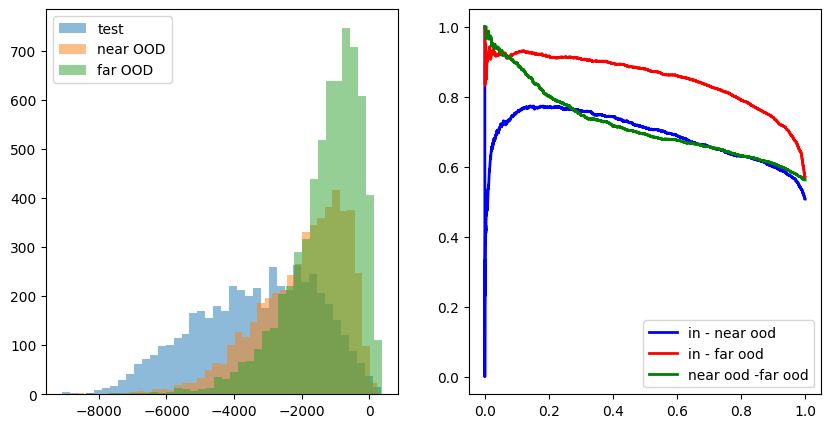

In [11]:
data_near = np.concatenate((test_score,near_ood_score))
t1 = np.zeros_like(test_score)
t2 = np.ones_like(near_ood_score)
data_label_n = np.concatenate((t1,t2))
plt.figure(figsize=(10,5))
plt.title("{}".format(maha.type))
plt.subplot(1,2,1)
ncounts, nbins = np.histogram(near_ood_score,bins=40)
tcounts, tbins = np.histogram(test_score,bins=40)
fcounts, fbins = np.histogram(far_ood_score,bins=40)

plt.hist(tbins[:-1], tbins, weights=tcounts, alpha=0.5,label = 'test')
plt.hist(nbins[:-1], nbins, weights=ncounts, alpha=0.5, label = 'near OOD')
plt.hist(fbins[:-1], fbins, weights=fcounts, alpha=0.5 , label= 'far OOD')
plt.legend()


plt.subplot(1,2,2)
precision, recall, _   = precision_recall_curve(data_label_n,data_near)
AUROC1 = roc_auc_score(data_label_n,data_near)
print(AUROC1)
plt.plot(recall, precision, lw=2, c='b', label='in - near ood')

data_far = np.concatenate((test_score,far_ood_score))
t1 = np.zeros_like(test_score)
t3 = np.ones_like(far_ood_score)
data_label_f = np.concatenate((t1,t3))
precision, recall, _   = precision_recall_curve(data_label_f,data_far)
AUROC2 = roc_auc_score(data_label_f,data_far)
print(AUROC2)
plt.plot(recall, precision, lw=2, c='r', label='in - far ood')

data = np.concatenate((near_ood_score,far_ood_score))
t2 = np.zeros_like(near_ood_score)
t3 = np.ones_like(far_ood_score)
data_label = np.concatenate((t2,t3))
precision, recall, _   = precision_recall_curve(data_label,data)
AUROC3 = roc_auc_score(data_label,data)
print(AUROC3)
plt.plot(recall, precision, lw=2, c='g', label='near ood -far ood')

plt.legend()
plt.show()